In [1]:
from credit.data import get_forward_data
from glob import glob
import os
import xarray as xr
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from os.path import join
from credit.xr_sampler import XRSamplerByYear
import yaml


import multiprocessing
from functools import partial

In [2]:
variable, level = "U", 24
ref_ens_member = 1

rollout_dir = "/glade/derecho/scratch/dkimpara/CREDIT_runs/skebs_fcnn_scaled_train/forecast"

# rollout_dir = "/glade/derecho/scratch/dkimpara/CREDIT_runs/unet_6_12h_pad/forecast"
eval_fh = 6
rollout_files = glob(join(rollout_dir, f"out_2012*/pred_out*{eval_fh:03}.nc")) + glob(join(rollout_dir, f"out_2013*/pred_out*{eval_fh:03}.nc"))
print(rollout_files)
forecast_hours = range(6, 240 + 1, 6)


['/glade/derecho/scratch/dkimpara/CREDIT_runs/skebs_fcnn_scaled_train/forecast/out_2012-12-30T00Z/pred_out_2012-12-30T00Z_006.nc', '/glade/derecho/scratch/dkimpara/CREDIT_runs/skebs_fcnn_scaled_train/forecast/out_2012-11-12T00Z/pred_out_2012-11-12T00Z_006.nc', '/glade/derecho/scratch/dkimpara/CREDIT_runs/skebs_fcnn_scaled_train/forecast/out_2012-09-25T00Z/pred_out_2012-09-25T00Z_006.nc', '/glade/derecho/scratch/dkimpara/CREDIT_runs/skebs_fcnn_scaled_train/forecast/out_2012-09-09T00Z/pred_out_2012-09-09T00Z_006.nc', '/glade/derecho/scratch/dkimpara/CREDIT_runs/skebs_fcnn_scaled_train/forecast/out_2012-07-23T00Z/pred_out_2012-07-23T00Z_006.nc', '/glade/derecho/scratch/dkimpara/CREDIT_runs/skebs_fcnn_scaled_train/forecast/out_2012-11-28T00Z/pred_out_2012-11-28T00Z_006.nc', '/glade/derecho/scratch/dkimpara/CREDIT_runs/skebs_fcnn_scaled_train/forecast/out_2012-08-24T00Z/pred_out_2012-08-24T00Z_006.nc', '/glade/derecho/scratch/dkimpara/CREDIT_runs/skebs_fcnn_scaled_train/forecast/out_2012-10

In [3]:
forecast_day = np.array(forecast_hours) / 24
def plot(std, error, label=None):
    plt.plot(forecast_day, std, label="std", c='tab:orange')
    plt.plot(forecast_day, error, label="rmse", c='b', marker="*")
    plt.xlabel("Day")
    plt.title(f"{variable}{level if variable in 'UVTQtot' else ''} {label} Spread-Error")
    plt.legend()
    plt.grid(True, markevery=(1,1))
    plt.show()

# compute with raw netcdfs

In [4]:
def get_data(rollout_files, variable, level):
    def select_darray(ds_given):
        ds_sel = ds_given[variable]
        if variable in "UVTQtot":
            return ds_sel.isel(level=level)
        return ds_sel

    # get pred and true data
    pred_da_list = []
    for file in rollout_files:
        ds = xr.open_dataset(file)
        da = select_darray(ds)
        pred_da_list.append(da)
    
    da_pred = xr.concat(pred_da_list, dim='time')
    return da_pred

## define metrics

### spread-error



In [5]:
def intra_ens_spread_error(variable, level, eval_fh):
    rollout_files = glob(join(rollout_dir, f"out_2012*/pred_out*{eval_fh:03}.nc"))# + glob(join(rollout_dir, f"out_2013*/pred_out*{eval_fh:03}.nc"))
    # rollout_files = glob(join(rollout_dir, f"*{eval_fh:03}.nc"))
    pred = get_data(rollout_files, variable, level)
    
    num_ensemble = pred.ensemble_member_label.shape[0]
    pred_sel = list(range(ref_ens_member)) + list(range(ref_ens_member + 1, num_ensemble)) 
    obs = pred.sel(ensemble_member_label=[ref_ens_member])

    pred = pred.sel(ensemble_member_label=pred_sel)

    std = pred.std(dim="ensemble_member_label")
    
    # average across members
    pred_mem = pred.sel(ensemble_member_label=pred_sel[0])
    error = np.sqrt((obs - pred_mem) ** 2)
    for member in pred_sel[1:]:
        pred_mem = pred.sel(ensemble_member_label=member)
        error += np.sqrt((obs - pred_mem) ** 2)

    error /= len(pred_sel)
    return (num_ensemble) / (num_ensemble - 2) * std, error


## run metrics

In [6]:
f = partial(intra_ens_spread_error, variable, level)
with multiprocessing.Pool(8) as p:
    
    result = p.map(f, range(6, 241, 6))

In [12]:
total_std = [res[0].mean() for res in result]
total_rmse = [res[1].mean() for res in result]

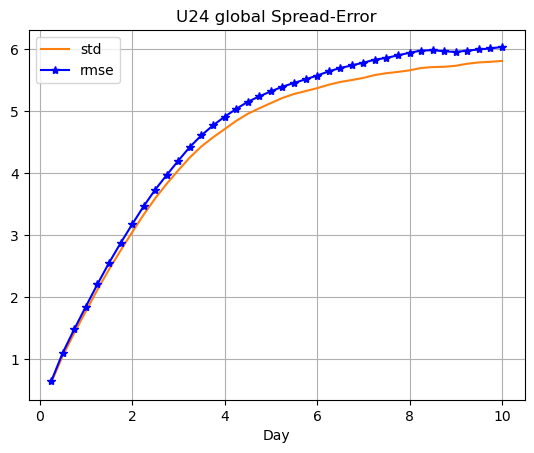

In [13]:
plot(total_std, total_rmse, "global")

In [9]:
n_std, n_error = [], []
t_std, t_error = [], []
s_std, s_error = [], []
total_std, total_error = [],[]

lat_wts = np.cos(np.deg2rad(result[0][0].latitude))
sum_wts = np.sum(lat_wts) * result[0][0].longitude.shape[0]

for res in result:
    std, error = res
    # std, error = std.mean(dim="longitude"), error.mean(dim="longitude")
    std = std * lat_wts / sum_wts
    error = error * lat_wts / sum_wts
    total_std.append(std.sum())
    total_error.append(error.sum())
    # total_std.append(std.sel(latitude=slice(24,91)).weighted(lat_wts).mean())
    # total_error.append(error.sel(latitude=slice(24,91)).weighted(lat_wts).mean())

    # n extratropics
    # n_std.append(std.sel(latitude=slice(24,91)).mean())
    # n_error.append(error.sel(latitude=slice(24,91)).mean())
    # # tropics
    # t_std.append(std.sel(latitude=slice(-24,24)).mean().values)
    # t_error.append(error.sel(latitude=slice(-24,24)).mean().values)
    # # s extra tropics
    # s_std.append(std.sel(latitude=slice(-91,-24)).mean().values)
    # s_error.append(error.sel(latitude=slice(-91,-24)).mean().values)
    

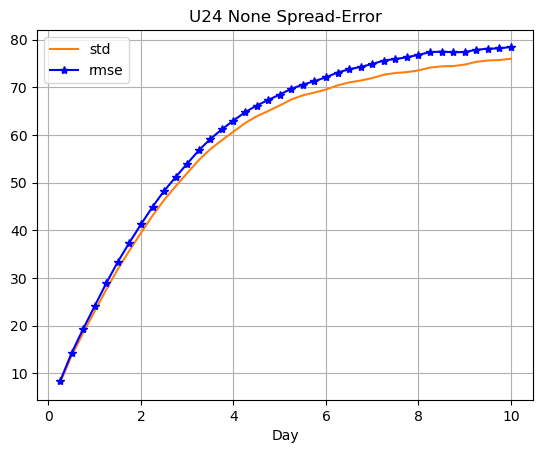

In [10]:
plot(total_std, total_error)

ValueError: x and y must have same first dimension, but have shapes (40,) and (0,)

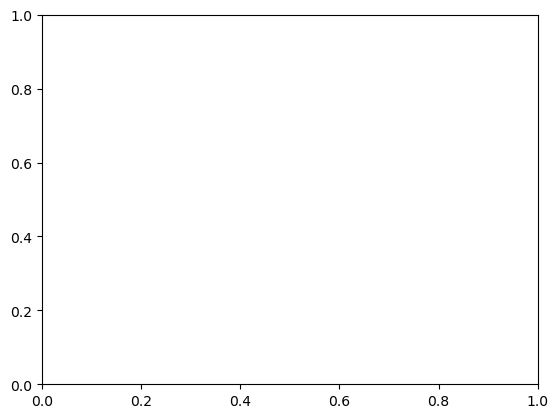

In [11]:
plot(n_std, n_error, "N extratropics")

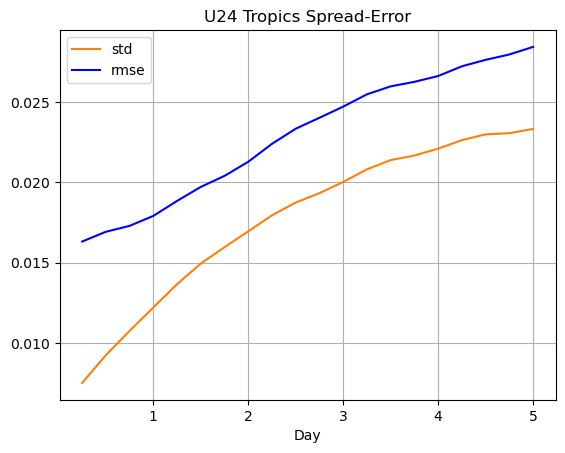

In [ ]:
plot(t_std, t_error, "Tropics")

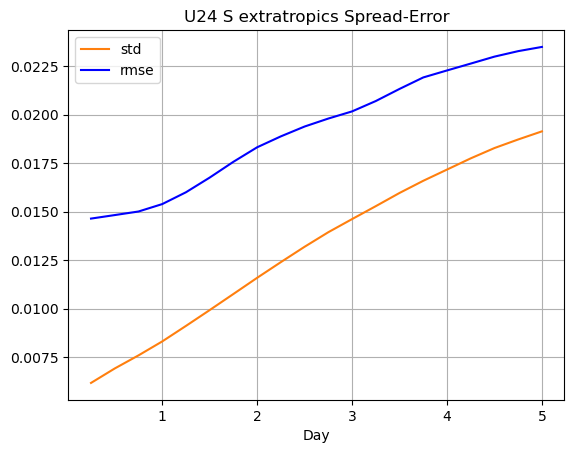

In [ ]:
plot(s_std, s_error, "S extratropics")

# compute with rollout_ens files

In [ ]:
# parallelize
static_ds = xr.open_dataset('/glade/campaign/cisl/aiml/wchapman/MLWPS/STAGING/f.e21.CREDIT_climate.statics_1.0deg_32levs_latlon_F32_hyai_fixed.nc')

lat_wts = np.cos(np.deg2rad(static_ds.latitude))
sum_wts = np.sum(lat_wts)

def spread_error_from_files(eval_fh):
    rmse_files = glob(join(rollout_dir, 'forecast/*/', f'pred_ens_rmse*{eval_fh:03}.nc'))
    std_files = glob(join(rollout_dir, 'forecast/*/', f'pred_ens_std*{eval_fh:03}.nc'))
    rmse_da = [xr.open_dataset(file)[variable].isel(level=level) for file in rmse_files]
    std_da = [xr.open_dataset(file)[variable].isel(level=level) for file in std_files]
    
    file_index = xr.DataArray(np.arange(len(rmse_files)), dims="file_number")
    rmse = xr.concat(rmse_da, file_index)
    std = xr.concat(std_da, file_index)

    # verif_rmse = (rmse.mean(dim=["longitude", "time", "file_number"]) * lat_wts).sum() / sum_wts
    # verif_std = (std.mean(dim=["longitude", "time", "file_number"]) * lat_wts).sum() / sum_wts
    verif_rmse = rmse.mean(dim=["longitude", "time", "file_number"])
    verif_std = std.mean(dim=["longitude", "time", "file_number"])
    return verif_rmse, verif_std

In [ ]:
with multiprocessing.Pool(4) as p:
    
    result = p.map(spread_error_from_files, forecast_hours)

In [ ]:
verif_rmse_lat, verif_std_lat = list(zip(*result))

In [ ]:
def plot_slice(rmse_lat, std_lat, slice, name):
    lat_wt_slice = lat_wts.sel(latitude=slice)
    sum_wts = np.sum(lat_wt_slice)
    plot([(rmse.sel(latitude=slice) * lat_wt_slice).sum() / sum_wts for rmse in rmse_lat], 
         [(std.sel(latitude=slice) * lat_wt_slice).sum() / sum_wts for std in std_lat], 
         name)


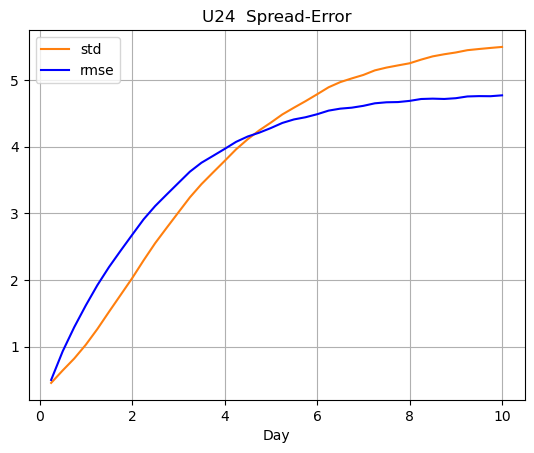

In [ ]:
plot_slice(verif_rmse_lat, verif_std_lat, slice(-91, 91), '')

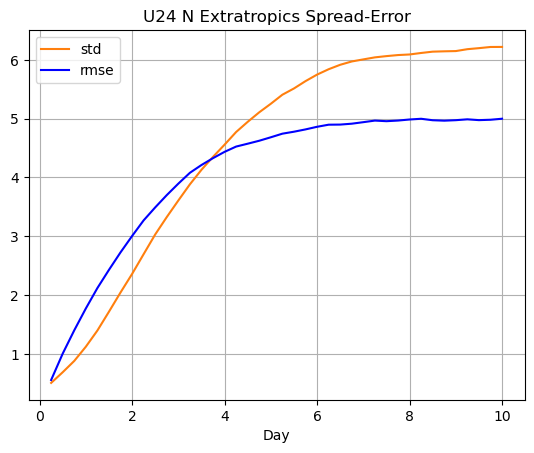

In [ ]:
plot_slice(verif_rmse_lat, verif_std_lat, slice(24.5, 91), 'N Extratropics')

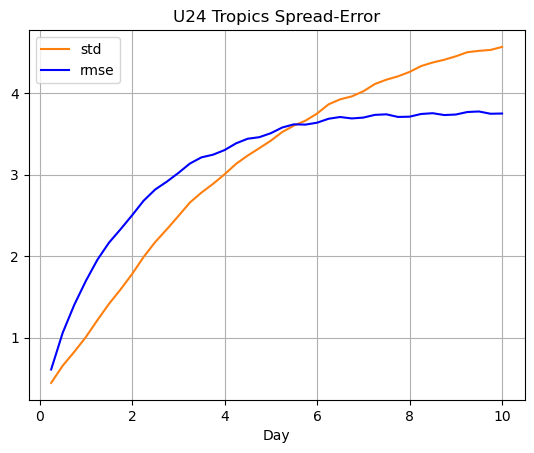

In [ ]:
plot_slice(verif_rmse_lat, verif_std_lat, slice(-24.5, 24.5), 'Tropics')

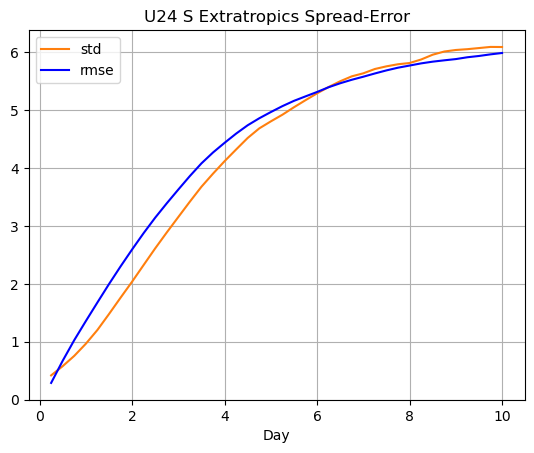

In [ ]:
plot_slice(verif_rmse_lat, verif_std_lat, slice(-91, -24.5), 'S Extratropics')